In [1]:
# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import the needed OGGM modules
from oggm import cfg, utils, workflow, graphics
from oggm.core import gis, climate, flowline, vascaling

In [5]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgi_ids = [rgi_id for rgi_id in rgidf.RGIId]

rgi_region = (rgi_ids[0].split('-')[-1]).split('.')[0]
rgi_version = (rgi_ids[0].split('-')[0])[-2:]

# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_wdir'
if not os.path.exists(wdir):
    os.makedirs(wdir)
# shutil.rmtree(wdir)
# os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 120
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False

# read RGI entry for the glaciers as DataFrame
# containing the outline area as shapefile
rgidf = utils.get_rgi_glacier_entities(rgi_ids)

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

# sort by area for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

# initialize the GlacierDirectory
gdirs = workflow.init_glacier_regions(rgidf)

2020-08-03 09:19:56: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


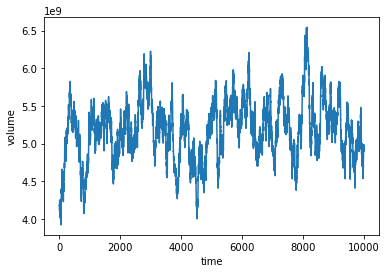

In [11]:
utils.compile_run_output(gdirs, filesuffix='_normal').volume.sum(dim='rgi_id').plot()

In [12]:
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_wdir'

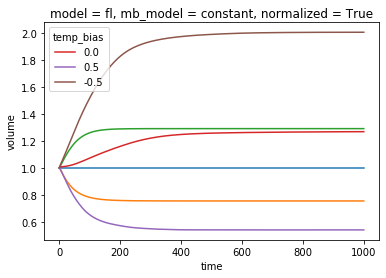

In [19]:
mb_model = 'constant'
model = 'vas'
ds = xr.open_dataset(os.path.join(wdir, 'run_output_{}_{}.nc'.format(mb_model, model)))
ds.sel(normalized=True).volume.plot.line(x='time')
ax = plt.gca()
mb_model = 'constant'
model = 'fl'
ds = xr.open_dataset(os.path.join(wdir, 'run_output_{}_{}.nc'.format(mb_model, model)))
ds.sel(normalized=True).volume.plot.line(x='time', ax=ax)

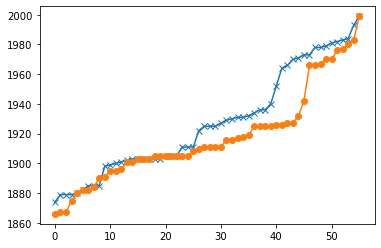

In [109]:
ref_df_oggm = pd.read_csv(utils.get_demo_file('oggm_ref_tstars_rgi6_histalp.csv'), index_col=0)
ref_df_vas = pd.read_csv(utils.get_demo_file('vas_ref_tstars_rgi6_histalp.csv'), index_col=0)
tstars_oggm = ref_df_oggm.tstar.values
tstars_vas = ref_df_vas.tstar.values
plt.plot(np.sort(tstars_oggm), marker='x')
plt.plot(np.sort(tstars_vas), marker='o')

56

In [110]:
ref_df_vas

,lon,lat,n_mb_years,tstar,bias
RGI60-11.00002,13.613500,47.484500,8,1911,25.030687
RGI60-11.00012,13.058100,47.424200,10,1967,1.894659
RGI60-11.00073,12.595600,47.140300,17,1983,6.710049
RGI60-11.00080,12.596400,47.131600,63,1932,2.570614
RGI60-11.00106,12.696700,47.099100,28,1890,-12.909590
RGI60-11.00190,12.378400,47.085100,8,1867,1.599925
RGI60-11.00251,12.947200,47.053000,16,1980,14.303069
RGI60-11.00289,12.970200,47.042100,26,1882,-0.175383
RGI60-11.00300,13.004900,47.038500,32,1917,0.670287
RGI60-11.00603,11.224700,46.965600,19,1911,382.336042


In [111]:
ref_df_oggm.tstar-ref_df_vas.tstar

RGI60-11.00002    -13
RGI60-11.00012    -33
RGI60-11.00073     -5
RGI60-11.00080      4
RGI60-11.00106    -10
RGI60-11.00190    117
RGI60-11.00251      3
RGI60-11.00289     89
RGI60-11.00300    -18
RGI60-11.00603      0
RGI60-11.00619    -16
RGI60-11.00638      0
RGI60-11.00647     99
RGI60-11.00719     98
RGI60-11.00781      0
RGI60-11.00787     39
RGI60-11.00797     15
RGI60-11.00804    -25
RGI60-11.00807      0
RGI60-11.00843     89
RGI60-11.00892    -24
RGI60-11.00897     22
RGI60-11.00918      0
RGI60-11.00929    -34
RGI60-11.01238      0
RGI60-11.01450    -63
RGI60-11.01662    -17
RGI60-11.01704    -21
RGI60-11.01776    -20
RGI60-11.01834     -2
RGI60-11.01876     -1
RGI60-11.01930    -21
RGI60-11.01987    -44
RGI60-11.02072    -59
RGI60-11.02214      0
RGI60-11.02245     12
RGI60-11.02249      0
RGI60-11.02285      0
RGI60-11.02648      0
RGI60-11.02671     11
RGI60-11.02679      5
RGI60-11.02704     58
RGI60-11.02746     12
RGI60-11.02764     70
RGI60-11.02766      6
RGI60-11.0

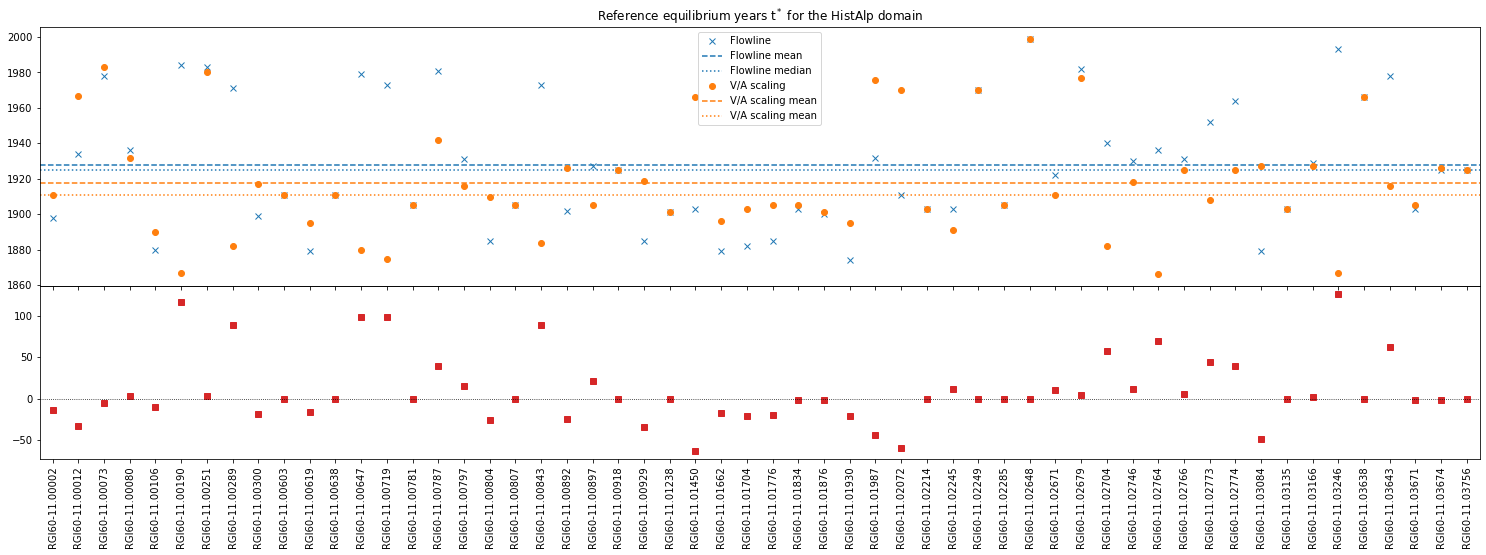

In [116]:
fig = plt.figure(figsize=[20,6])

ax = fig.add_axes([0,0,1,0.4])
ax.plot(ref_df_oggm.tstar-ref_df_vas.tstar, c='tab:red', ls='', marker='s')
ax.axhline(0, ls=':', lw=0.8, c='k')
ax.set_xlim([-0.5,len(ref_df_oggm)-0.5])
plt.xticks(rotation=90);

ax = fig.add_axes([0,0.4,1,0.6])
ax.plot(ref_df_oggm.tstar, ls='', marker='x', label='Flowline', c='tab:blue')
ax.axhline(ref_df_oggm.tstar.mean(), ls='--', c='tab:blue', label='Flowline mean')
ax.axhline(ref_df_oggm.tstar.median(), ls=':', c='tab:blue', label='Flowline median')

ax.plot(ref_df_vas.tstar, ls='', marker='o', label='V/A scaling', c='tab:orange')
ax.axhline(ref_df_vas.tstar.mean(), ls='--', c='tab:orange', label='V/A scaling mean')
ax.axhline(ref_df_vas.tstar.median(), ls=':', c='tab:orange', label='V/A scaling mean')

ax.set_xticklabels([])
plt.xlim([-0.5,len(ref_df_oggm)-0.5])
plt.title('Reference equilibrium years t$^*$ for the HistAlp domain')
plt.legend(title='')

{'whiskers': [<matplotlib.lines.Line2D at 0x12b885ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x12b885358>,
 'boxes': [<matplotlib.lines.Line2D at 0x12b885c88>,
 'medians': [<matplotlib.lines.Line2D at 0x12b87e780>,
 'fliers': [<matplotlib.lines.Line2D at 0x12b87e940>,
 'means': []}

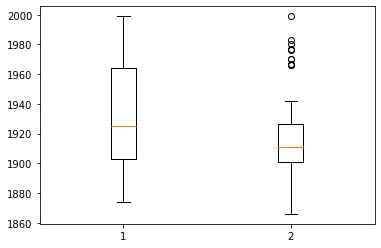

In [119]:
plt.boxplot([ref_df_oggm.tstar, ref_df_vas.tstar])

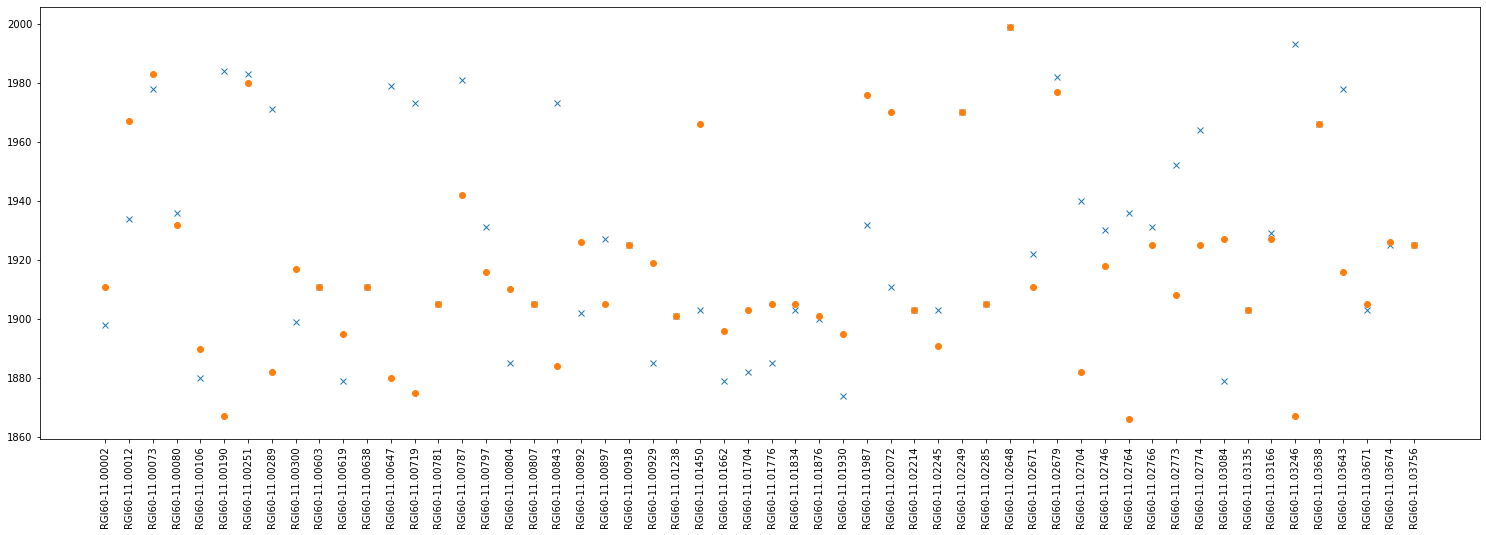

In [84]:
fig = plt.figure(figsize=[20,6])
ax = fig.add_axes([0,0,1,1])

ax.plot(ref_df_oggm.tstar, ls='', marker='x', label='Flowline')
ax.plot(ref_df_vas.tstar, ls='', marker='o', label='V/A scaling')
plt.xticks(rotation=90);

In [82]:
l

<a list of 56 Text xticklabel objects>

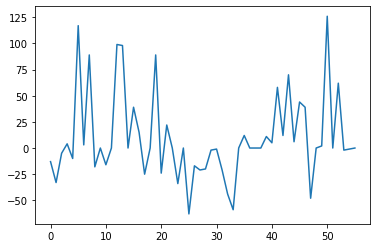

In [43]:
plt.plot(tstars_oggm-tstars_vas)

In [ ]:
rgi_ids = ['RGI60-11.00747']
tstar = 1927
kwargs = dict()

In [ ]:
# compute RGI region and version from RGI IDs
# assuming all they are all the same
rgi_region = (rgi_ids[0].split('-')[-1]).split('.')[0]
rgi_version = (rgi_ids[0].split('-')[0])[-2:]

# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_notebook_wdir'
if not os.path.exists(wdir):
    os.makedirs(wdir)
# shutil.rmtree(wdir)
# os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 120
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False

# read RGI entry for the glaciers as DataFrame
# containing the outline area as shapefile
rgidf = utils.get_rgi_glacier_entities(rgi_ids)

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

# sort by area for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(8, 6))

for ax, border in zip(np.array(axs).flatten(), [10, 80, 160, 250]):
    cfg.PARAMS['border'] = border
    gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True)
    graphics.plot_domain(gdirs[0], ax=ax, title='Border: {}'.format(border),
                         add_colorbar=False,
                         lonlat_contours_kwargs={'add_tick_labels':False})

plt.tight_layout(); plt.show()

In [ ]:
# set border parameter
cfg.PARAMS['border'] = 40

# initialize the GlacierDirectory
gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True)

# run gis tasks
workflow.gis_prepro_tasks(gdirs)
# run climate tasks
workflow.execute_entity_task(climate.process_histalp_data, gdirs)
workflow.execute_entity_task(climate.local_t_star, gdirs,
                             tstar=tstar, bias=0)
workflow.execute_entity_task(climate.mu_star_calibration, gdirs)
# run inversion tasks
workflow.inversion_tasks(gdirs)
# finalize preprocessing
workflow.execute_entity_task(flowline.init_present_time_glacier, gdirs)

# use t* as center year, even if specified differently
kwargs['y0'] = tstar
# run for 3000 years if not specified otherwise
kwargs.setdefault('nyears', 3000)

In [ ]:
kwargs['nyears'] = 1e3
model = workflow.execute_entity_task(flowline.run_random_climate, gdirs, 
                             temperature_bias=0, output_filesuffix='_test',
                             **kwargs)

In [ ]:
m = model[0]
m.fls[0].rgi_id

In [ ]:
for i in model:
    print(i)

In [ ]:
ds = utils.compile_run_output(gdirs, filesuffix='_test')

In [ ]:
graphics.plot_modeloutput_map(gdirs[0], model=model, filesuffix='_test')

In [ ]:
ds.volume.plot()

In [120]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgi_ids = [rgi_id for rgi_id in rgidf.sort_values('Area', ascending=False).RGIId]

In [121]:
rgi_ids

['RGI60-11.00719',
 'RGI60-11.00897',
 'RGI60-11.00945',
 'RGI60-11.00958',
 'RGI60-11.00787',
 'RGI60-11.00943',
 'RGI60-11.00957',
 'RGI60-11.00886',
 'RGI60-11.00779',
 'RGI60-11.00720',
 'RGI60-11.00782',
 'RGI60-11.00844',
 'RGI60-11.00674',
 'RGI60-11.00885',
 'RGI60-11.00834',
 'RGI60-11.00919',
 'RGI60-11.00822',
 'RGI60-11.00962',
 'RGI60-11.00860',
 'RGI60-11.00904',
 'RGI60-11.00731',
 'RGI60-11.00944',
 'RGI60-11.00862',
 'RGI60-11.00937',
 'RGI60-11.00739',
 'RGI60-11.00745',
 'RGI60-11.00959',
 'RGI60-11.00895',
 'RGI60-11.00726',
 'RGI60-11.00888',
 'RGI60-11.00702',
 'RGI60-11.00718',
 'RGI60-11.00762',
 'RGI60-11.00753',
 'RGI60-11.00927',
 'RGI60-11.00935',
 'RGI60-11.00839',
 'RGI60-11.00898',
 'RGI60-11.00831',
 'RGI60-11.00814',
 'RGI60-11.00902',
 'RGI60-11.00802',
 'RGI60-11.00729',
 'RGI60-11.00984',
 'RGI60-11.00980',
 'RGI60-11.00737',
 'RGI60-11.00675',
 'RGI60-11.00947',
 'RGI60-11.00724',
 'RGI60-11.00757',
 'RGI60-11.00690',
 'RGI60-11.00873',
 'RGI60-11.0

In [ ]:
nc_new = utils.ncDataset(gdirs[0].get_filepath('gridded_data'))
nc_new

In [ ]:
nc = utils.ncDataset(gdirs[0].get_filepath('gridded_data'))
nc

In [ ]:
graphics.plot_centerlines(gdirs, add_downstream=True, use_flowlines=True)
graphics.plot_googlemap(gdirs)

In [ ]:
graphics.plot_domain(gdirs)

In [ ]:
graphics.plot_centerlines(gdirs, add_downstream=True, use_flowlines=True)
graphics.plot_googlemap(gdirs)

In [ ]:
rgidf

In [ ]:
# test t_star with reference dataframe
ref_df = pd.read_csv(utils.get_demo_file('oggm_ref_tstars_rgi6_histalp.csv'), index_col=0)
kwargs.setdefault('ref_df', ref_df)
vascaling.local_t_star(gdirs[0], **kwargs)

In [ ]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgidf = rgidf.sort_values('Area', ascending=False)
rgi_ids = [rgi_id for rgi_id in rgidf.RGIId]

In [ ]:
rgi_ids[]

In [ ]:
model

In [ ]:
ds = utils.compile_run_output(np.atleast_1d(gdirs), filesuffix='_test', path=False)

In [ ]:
model = flowline.FileModel(gdirs[0].get_filepath('model_run', filesuffix='_test'))

In [ ]:
graphics.plot_modeloutput_map(gdirs[0], model=model)

In [ ]:
graphics.plot_distributed_thickness(gdirs)

In [ ]:
ds.area.plot()

In [ ]:
# define RGI IDs
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgidf = rgidf.sort_values('Area', ascending=False)
rgi_ids = [rgi_id for rgi_id in rgidf.RGIId]
rgi_ids

In [ ]:
rgi_ids

In [ ]:
# load dataset
path = '/Users/oberrauch/work/master/data/eq_runs/rofental_vas.nc'
ds = xr.open_dataset(path)

In [ ]:
ds.sel(normalized=True).volume.plot.line(x='time')

In [ ]:
ds.close()

In [ ]:
# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import the needed OGGM modules
from oggm import cfg, utils, workflow, graphics
from oggm.core import gis, climate, flowline, vascaling

In [ ]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_wdir'
cfg.PATHS['working_dir'] = wdir

In [ ]:
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = '6'
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 120
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region='11')
cfg.set_intersects_db(intersects_db)

In [ ]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgidf

In [ ]:
workflow.init_glacier_regions(rgidf)

In [ ]:
ds_ = utils.compile_run_output()

In [ ]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_notebook_wdir'